In [323]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [357]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
data_directory = './data/lunar/training/data/S12_GradeA/'

TRAINING_RELATION = 0.8
WINDOW_SIZE = 12

cat = pd.read_csv(cat_file)

In [358]:
# Power, bandwidth, spectral entropy, peak frequency, dominant frequency, centroid frequency, mean frequency and spectral amplitude

def get_power(dataframe):
    # The power of a signal is the sum of the squares of the absolute values of the signal's time-domain samples divided by the signal length
    data = dataframe.data

    return np.sum(np.abs(data)**2)

def get_bandwidth(dataframe):
    # The bandwidth of a signal is the range of frequencies that it contains
    data = dataframe.data
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft)**2)

def get_spectral_entropy(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)
    power = np.abs(fft)**2
    power = power / np.sum(power)  # Normalización
    power = power[power > 0]  # Evitar log(0)

    return -np.sum(power * np.log(power))

def get_peak_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.abs(freqs[np.argmax(np.abs(fft))])

def get_dominant_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.abs(freqs[np.argmax(np.abs(fft))])

def get_centroid_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft) * np.abs(freqs)) / np.sum(np.abs(fft))

def get_mean_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft) * np.abs(freqs)) / np.sum(np.abs(fft))

def get_spectral_amplitude(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)

    return np.max(np.abs(fft))

def get_characteristics(dataframe):
    power = get_power(dataframe)
    bandwidth = get_bandwidth(dataframe)
    spectral_entropy = get_spectral_entropy(dataframe)
    peak_frequency = get_peak_frequency(dataframe)
    dominant_frequency = get_dominant_frequency(dataframe)
    centroid_frequency = get_centroid_frequency(dataframe)
    mean_frequency = get_mean_frequency(dataframe)
    spectral_amplitude = get_spectral_amplitude(dataframe)

    return dict(
        power=power,
        bandwidth=bandwidth,
        spectral_entropy=spectral_entropy,
        peak_frequency=peak_frequency,
        dominant_frequency=dominant_frequency,
        centroid_frequency=centroid_frequency,
        mean_frequency=mean_frequency,
        spectral_amplitude=spectral_amplitude
    )

def get_file_data(index: int):
    catalog_row = cat.iloc[index]

    filename = catalog_row.filename

    csv_file = f'{data_directory}{filename}.csv'
    data_cat = pd.read_csv(csv_file)

    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())
    event_time = catalog_row['time_rel(sec)']

    return dict(
        times=csv_times,
        data=csv_data,
        filename=filename,
        event_time=event_time
    )

def get_windowed_data(dataframe, windows=WINDOW_SIZE):
    data = dataframe.data
    times = dataframe.time
    types = dataframe.type

    window_size = len(data) // windows

    windowed_dataframes = []

    for i in range(windows):
        start = i * window_size
        end = (i + 1) * window_size

        window_data = data[start:end]
        window_times = times[start:end]
        window_types = types[start:end]

        windowed_dataframes.append(pd.DataFrame(dict(
            time=window_times,
            data=window_data,
            type=window_types
        )))

    return windowed_dataframes

def get_tagged_data(untagged_data):
    list = []
    times = untagged_data['times']
    data = untagged_data['data']
    event_time = untagged_data['event_time']

    for i in range(len(times)):
        row = dict(
            time=times[i],
            data=data[i],
            type = 0 if times[i] < event_time else 1
        )
        list.append(row)
    
    return pd.DataFrame(list)

def get_window_type(window):
    # if there is only 0s, is a non-event window
    if np.all(window.type == 0):
        return 0
    # if there is only 1s, is a non-event window
    if np.all(window.type == 1):
        return 2
    # if there is at least one 1, is an event window
    if np.any(window.type == 1):
        return 1
    
    return -1
    

def get_dataset_characteristics():
    characteristics = []
    limit = cat.shape[0]

    for i in range(1, limit):
        row = cat.iloc[i]
        filename = row.filename

        csv_file = f'{data_directory}{filename}.csv'
        data_cat = pd.read_csv(csv_file)

        csv_times = np.array(data_cat['time_rel(sec)'].tolist())
        csv_data = np.array(data_cat['velocity(m/s)'].tolist())

        characteristics.append(dict(
            **get_characteristics(csv_data, csv_times)
        ))
        print(f'Processed training file {i}/{limit - 1} ({filename})')

    return pd.DataFrame(characteristics, ignore_index=True)

def get_windows_characteristics(windows):
    characteristics = []

    for i in range(len(windows)):
        window = windows[i]
        window_type = get_window_type(window)

        characteristics.append(dict(
            is_event=1 if window_type == 1 else 0,
            **get_characteristics(window)
        ))
        print(f'Processed window {i}/{len(windows)}')

    return pd.DataFrame(characteristics)
    

In [372]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential([
    Input(shape=(8,)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [360]:
def get_all_windowd_data():
    file_count = cat.shape[0]
    windows = []

    for i in range(0, file_count):
        untagged_data = get_file_data(i)
        tagged_data = get_tagged_data(untagged_data)
        windowed_data = get_windowed_data(tagged_data)

        for window in windowed_data:
            windows.append(window)

        print(f'Processed training file {i}/{file_count - 1} ({untagged_data["filename"]})')
    
    return windows


In [361]:
windows = get_all_windowd_data()

Processed training file 0/75 (xa.s12.00.mhz.1970-01-19HR00_evid00002)
Processed training file 1/75 (xa.s12.00.mhz.1970-03-25HR00_evid00003)
Processed training file 2/75 (xa.s12.00.mhz.1970-03-26HR00_evid00004)
Processed training file 3/75 (xa.s12.00.mhz.1970-04-25HR00_evid00006)
Processed training file 4/75 (xa.s12.00.mhz.1970-04-26HR00_evid00007)
Processed training file 5/75 (xa.s12.00.mhz.1970-06-15HR00_evid00008)
Processed training file 6/75 (xa.s12.00.mhz.1970-06-26HR00_evid00009)
Processed training file 7/75 (xa.s12.00.mhz.1970-07-20HR00_evid00010)
Processed training file 8/75 (xa.s12.00.mhz.1970-07-20HR00_evid00011)
Processed training file 9/75 (xa.s12.00.mhz.1970-09-26HR00_evid00013)
Processed training file 10/75 (xa.s12.00.mhz.1970-10-24HR00_evid00014)
Processed training file 11/75 (xa.s12.00.mhz.1970-11-12HR00_evid00015)
Processed training file 12/75 (xa.s12.00.mhz.1970-12-11HR00_evid00017)
Processed training file 13/75 (xa.s12.00.mhz.1970-12-27HR00_evid00019)
Processed traini

In [362]:
noise_windows = [window for window in windows if get_window_type(window) != 1]
event_windows = [window for window in windows if get_window_type(window) == 1]

np.random.shuffle(noise_windows)

noise_windows = noise_windows[:len(event_windows)]

# mix the noise and event windows
normalized_windows = noise_windows + event_windows
# shuffle the windows
np.random.shuffle(normalized_windows)


1
1
1
1
0
1
0
2
2
0
1
0
2
1
2
0
0
2
0
1
1
1
1
0
2
0
2
1
0
1
1
1
1
2
1
2
1
2
2
1
2
0
1
1
1
0
1
1
0
0
2
1
2
1
2
2
1
2
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
2
2
1
0
2
1
1
2
1
0
1
0
1
0
1
0
2
2
2
1
0
1
1
2
1
2
0
1
0
2
1
2
2
2
2
1
1
1
0
1
0
0
1
2
0
2
2
0
1
1
1
2
1
1
0
2
0
1
1
1
2
0
1
2
1
1
1
2
1
1
2
0
0
1
1
0
2
1
1


In [367]:
windows_characteristics = get_windows_characteristics(normalized_windows)

# Split windows_characteristics into training and testing
training_limit = int(len(windows_characteristics) * TRAINING_RELATION)

training_data = windows_characteristics[:training_limit]
testing_data = windows_characteristics[training_limit:]

Processed window 0/152
Processed window 1/152
Processed window 2/152
Processed window 3/152
Processed window 4/152
Processed window 5/152
Processed window 6/152
Processed window 7/152
Processed window 8/152
Processed window 9/152
Processed window 10/152
Processed window 11/152
Processed window 12/152
Processed window 13/152
Processed window 14/152
Processed window 15/152
Processed window 16/152
Processed window 17/152
Processed window 18/152
Processed window 19/152
Processed window 20/152
Processed window 21/152
Processed window 22/152
Processed window 23/152
Processed window 24/152
Processed window 25/152
Processed window 26/152
Processed window 27/152
Processed window 28/152
Processed window 29/152
Processed window 30/152
Processed window 31/152
Processed window 32/152
Processed window 33/152
Processed window 34/152
Processed window 35/152
Processed window 36/152
Processed window 37/152
Processed window 38/152
Processed window 39/152
Processed window 40/152
Processed window 41/152
Pr

In [373]:
x_train = training_data.drop(columns=['is_event'])
y_train = training_data[['is_event']]

history = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100


c:\Users\coljop\OneDrive - SAS\1.PERSONAL\HCK102024\nasa-app\.venv\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5456 - loss: 0.0000e+00 - val_accuracy: 0.3200 - val_loss: 0.0000e+00
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4831 - loss: 0.0000e+00 - val_accuracy: 0.3200 - val_loss: 0.0000e+00
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4714 - loss: 0.0000e+00 - val_accuracy: 0.3200 - val_loss: 0.0000e+00
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6250 - loss: 0.0000e+00

c:\Users\coljop\OneDrive - SAS\1.PERSONAL\HCK102024\nasa-app\.venv\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5690 - loss: 0.0000e+00 - val_accuracy: 0.5200 - val_loss: 0.0000e+00
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5094 - loss: 0.0000e+00 - val_accuracy: 0.5600 - val_loss: 0.0000e+00
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4544 - loss: 0.0000e+00 - val_accuracy: 0.6800 - val_loss: 0.0000e+00
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5247 - loss: 0.0000e+00 - val_accuracy: 0.6800 - val_loss: 0.0000e+00
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4562 - loss: 0.0000e+00 - val_accuracy: 0.6800 - val_loss: 0.0000e+00
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4349 - loss: 0.0000e+00 - val_accuracy: 0.6800 - val_loss: 0.0000e+00
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4583 - loss: 0.0000e+00 - val_accuracy: 0.6800 - val_loss: 0.0000e+00
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4661 - loss

In [374]:
x_test = testing_data.drop(columns=['is_event'])
y_test = testing_data[['is_event']]

accuracy, loss = model.evaluate(x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4194 - loss: 0.0000e+00


In [375]:
accuracy, loss

(0.0, 0.4193548262119293)

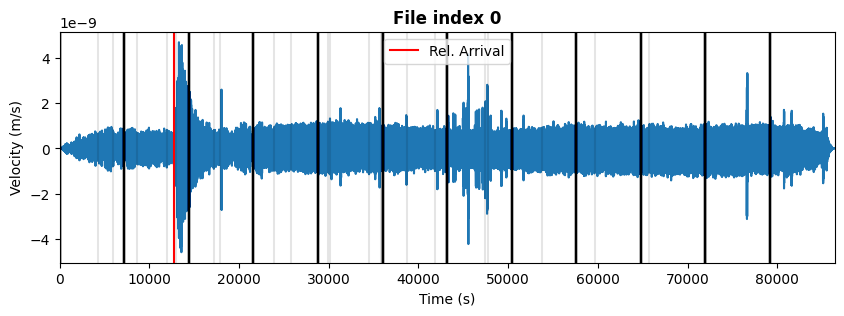

In [413]:
final_test = get_file_data(0)
times = final_test['times']
data = final_test['data']
event_time = final_test['event_time']

# plot
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(times, data)

# Make the plot pretty
ax.set_xlim([min(times), max(times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'File index 0', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=event_time, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# draw a line for each window and its number
for i in range(len(windows)):
    window = windows[i]
    ax.axvline(x=window.time.iloc[0], c='black', alpha=0.1)


plt.show()

# adaboost
# xgboost

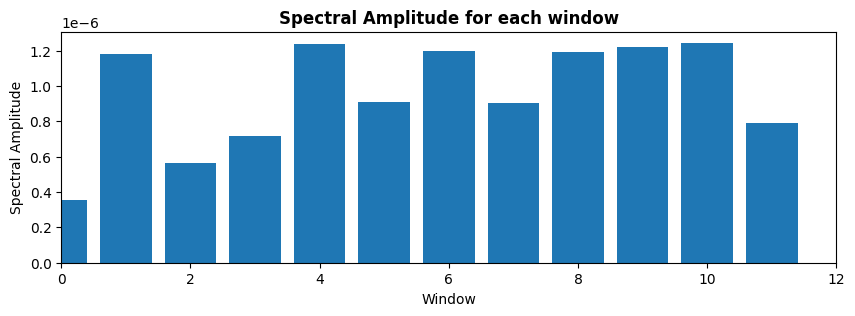

In [414]:
# Lets to predict the windows
windowed_data = get_windowed_data(pd.DataFrame(dict(
    time=times,
    data=data,
    type=[0] * len(times)
)))

mean_amplitudes = []

for window in windowed_data:
    mean_amplitudes.append(get_characteristics(window)['spectral_amplitude'])

mean_amplitudes = np.array(mean_amplitudes)

# Plot with a bar for each window the spectral amplitude
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.bar(range(len(mean_amplitudes)), mean_amplitudes)

# Make the plot pretty
ax.set_xlim([0, len(mean_amplitudes)])
ax.set_ylabel('Spectral Amplitude')
ax.set_xlabel('Window')
ax.set_title(f'Spectral Amplitude for each window', fontweight='bold')

plt.show()

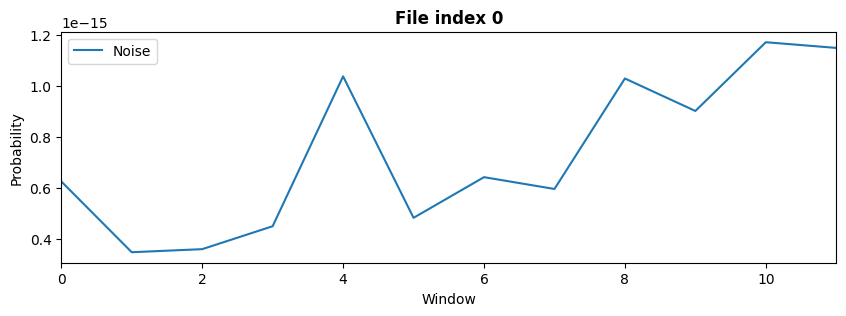

In [416]:
w_counts = [x for x in range(len(predictions))]
w_counts = np.array(w_counts)

fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(w_counts, predictions[:, 0], label='Noise')

# Make the plot pretty
ax.set_xlim([min(w_counts), max(w_counts)])
ax.set_ylabel('Probability')
ax.set_xlabel('Window')
ax.set_title(f'File index 0', fontweight='bold')
ax.legend()

plt.show()

In [9]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV

# model = MLPClassifier(hidden_layer_sizes=(16, 16), activation='relu', solver='adam', max_iter=1000)
# dataset_characteristics

In [16]:
training_characteristics = dataset_characteristics.sample(frac=TRAINING_RELATION)
test_characteristics = dataset_characteristics.drop(training_characteristics.index)

In [17]:
history = model.fit(
    training_characteristics[['power', 'bandwidth', 'spectral_entropy', 'peak_frequency', 'dominant_frequency', 'centroid_frequency', 'mean_frequency', 'spectral_amplitude']],
    training_characteristics[['mq_type']],
    epochs=100,
    batch_size=4
)

Epoch 1/100


c:\Users\coljop\OneDrive - SAS\1.PERSONAL\HCK102024\nasa-app\.venv\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(4, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8839 - loss: 0.0000e+000
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7688 - loss: 0.0000e+00
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9053 - loss: 0.0000e+00 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.8310 - loss: 0.0000e+00
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8837 - loss: 0.0000e+00 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8631 - loss: 0.0000e+00
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9094 - loss: 0.0000e+00
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8241 - loss: 0.0000e+00 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8520 - loss: 0.0000e+00
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8188 - loss: 0.0000e+00 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - loss: 0.0000e+00
Epoch 12/100
15/15 ━━━━━

In [20]:
test_loss, test_accuracy = model.evaluate(
    test_characteristics[['power', 'bandwidth', 'spectral_entropy', 'peak_frequency', 'dominant_frequency', 'centroid_frequency', 'mean_frequency', 'spectral_amplitude']],
    test_characteristics[['mq_type']]
)

print(f'Test accuracy: {test_accuracy * 100}%')
print(f'Test loss: {test_loss}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7333 - loss: 0.0000e+00
Test accuracy: 73.33333492279053%
Test loss: 0.0


In [84]:
# 'min_samples_split': range(2, 18, 3) | 17, 5, 9, 2 MEJORES
# 'max_depth': [1, 3, 7, 12, 15, 18, 20, None] | 20
# 'max_features': [3, 4, 5, 6, None] | 5 MEJOR
# 'min_samples_leaf': range(3,18,3) | 6 MEJOR
# 'ccp_alpha':[X0.0, 0.001, 0.005,0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.05] | 0.0 MEJOR

mlp_hyp_grid = {'hidden_layer_sizes': [(16, 8), (32, 32), (64, 64), (128, 128), (256, 256)],
                'activation': ['relu', 'tanh', 'logistic'],
                'solver': ['adam'],
            }
mdl_tree = GridSearchCV(MLPClassifier(), param_grid=mlp_hyp_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1).fit(dataset_characteristics[['power', 'bandwidth', 'spectral_entropy', 'peak_frequency', 'dominant_frequency', 'centroid_frequency', 'mean_frequency', 'spectral_amplitude']], dataset_characteristics[['mq_type']])
mdl_tree.best_params_
mdl_tree.best_score_

c:\Users\maria\OneDrive\Escritorio\_\NSAC\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\.venv\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\maria\OneDrive\Escritorio\_\NSAC\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4666666666666666

In [83]:
mdl_tree.best_score_

0.4666666666666666